In [1]:
import pandas as pd
import pickle

In [2]:
combined_df = pd.read_pickle('../../data/combined_analysis_data.pkl')
combined_df.head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,...,Flipping_the_Narrative,downvoted,moderator,downvoted_user,deleted_user,log_nword,user_flair,pt_user_count,pt_user_mean,pt_score
index,,,,,,,,,,,,,,,,,,,,,
2490481,-0.469738,-0.450741,-0.460415,-0.514128,-0.468683,-0.465732,-0.445607,-0.416617,-0.387825,1.437807,...,-0.034424,-0.098938,-0.011314,-0.046315,-0.165895,0.679459,1.082047,-0.214914,-0.420876,-1.207604
2490482,-0.469738,-0.450741,-0.460415,0.751681,-0.468683,-0.465732,1.748294,-0.416617,-0.387825,-0.455476,...,-0.034424,-0.098938,-0.011314,-0.046315,-0.165895,0.056112,1.082047,0.247121,1.785519,0.171363
2490483,-0.346310,-0.323680,-0.339484,-0.415414,-0.356224,-0.328610,-0.282506,-0.227255,-0.186713,-0.293744,...,-0.034424,-0.098938,-0.011314,-0.046315,-0.165895,-0.639216,1.082047,0.298072,0.829723,-0.112168
2490484,-0.469738,-0.450741,6.469216,-0.514128,-0.468683,-0.465732,-0.445607,-0.416617,-0.387825,-0.455476,...,-0.034424,-0.098938,-0.011314,-0.046315,-0.165895,-0.179831,1.082047,0.984762,0.840029,0.885040
2490485,-0.469738,-0.450741,-0.460415,4.390862,-0.468683,-0.465732,-0.445607,-0.416617,-0.387825,-0.455476,...,-0.034424,-0.098938,-0.011314,-0.046315,-0.165895,0.348764,1.082047,0.450655,1.779131,0.790891


In [5]:
combined_df.columns

Index(['lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7',
       'lda_8', 'lda_9', 'lda_10', 'lda_11', 'lda_12', 'lda_13', 'lda_14',
       'lda_15', 'lda_16', 'controversiality', 'gilded', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'Stoicism',
       'Physical_Violence', 'Hostility', 'Homophobia', 'Sexual_Violence',
       'Patriarchy', 'Belitting', 'Racism', 'Flipping_the_Narrative',
       'downvoted', 'moderator', 'downvoted_user', 'deleted_user', 'log_nword',
       'user_flair', 'pt_user_count', 'pt_user_mean', 'pt_score'],
      dtype='object')

In [9]:
from sklearn.cluster import KMeans

plot_kmk = []
mod_kmk = []
for k in range(1, 100, 5):
    km_k = KMeans(n_clusters = k)
    km_k.fit(combined_df)
    plot_kmk.append(km_k.inertia_)
    mod_kmk.append(km_k)

Text(0, 0.5, 'Sum Squared Distance')

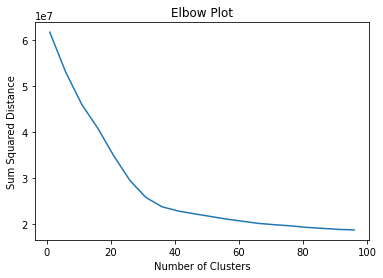

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, 100, 5), plot_kmk)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum Squared Distance')

Even using 20 clusters, we aren't getting a substantial reduction in SSD - certainly not one that makes any real improvement on the LDA inputs we got from the text in the first place. The real reduction is around 30 clusters - this may be the ideal number to avoid overfitting, but it is fairly high number of clusters to reason about so we need to do some summary statistics to see whether they have any meaning.

In [3]:
from sklearn.cluster import KMeans
best_mod = KMeans(n_clusters = 30)
best_mod.fit(combined_df)

KMeans(n_clusters=30)

In [6]:
filehandler = open('best_kmeans.pkl', 'wb') 
pickle.dump(best_mod, filehandler)

In [7]:
combined_df['cluster'] = best_mod.labels_

In [8]:
#how about lexicon proportions by cluster?
rs_cluster = combined_df.groupby('cluster')[['Racism', 'Physical_Violence','Sexual_Violence', 'Homophobia', 'Patriarchy']].mean()

<AxesSubplot:xlabel='Racism', ylabel='Physical_Violence'>

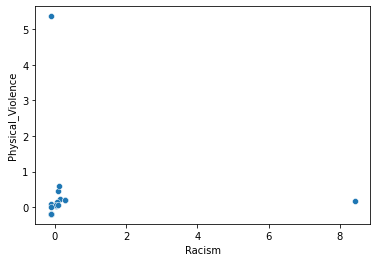

In [14]:
import seaborn as sns
sns.scatterplot(data = rs_cluster, x = 'Racism', y='Physical_Violence')

<AxesSubplot:xlabel='Sexual_Violence', ylabel='Physical_Violence'>

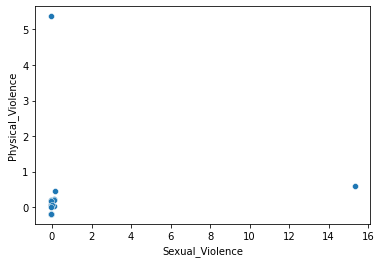

In [15]:
sns.scatterplot(data = rs_cluster, x = 'Sexual_Violence', y='Physical_Violence')

<AxesSubplot:xlabel='Sexual_Violence', ylabel='Patriarchy'>

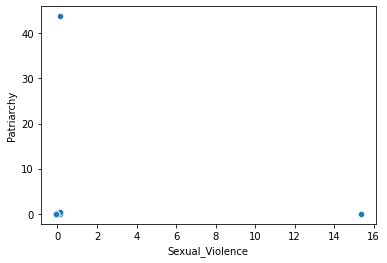

In [16]:
sns.scatterplot(data = rs_cluster, x = 'Sexual_Violence', y='Patriarchy')

In [41]:
#lets try something that wasn't binary in the first place - scores and counts
sc_cluster = combined_df.groupby('cluster')[['pt_user_mean', 'pt_user_count', 'pt_score']].mean()
sc_cluster.reset_index('cluster', inplace=True)



,cluster,variable,value
0,0,pt_user_mean,0.051326
1,1,pt_user_mean,0.012361
2,2,pt_user_mean,-0.026090
3,3,pt_user_mean,0.091816
4,4,pt_user_mean,0.051372


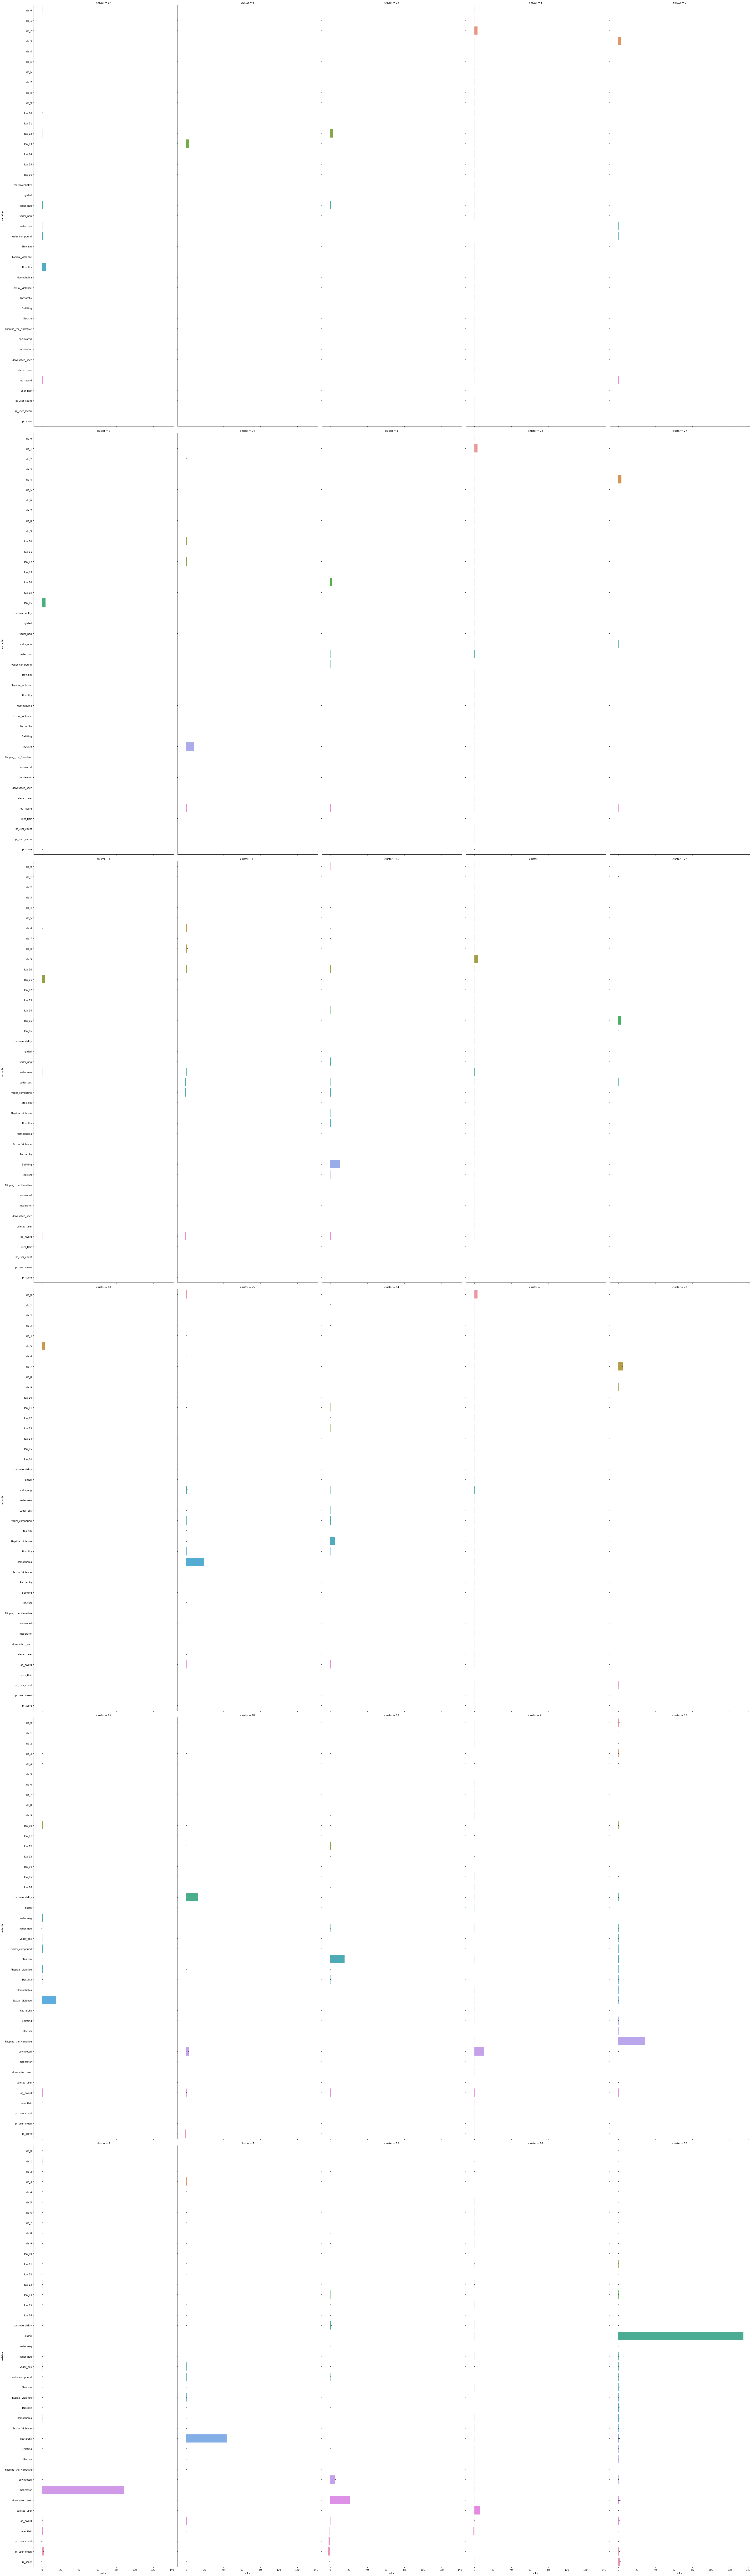

In [43]:
# sns.set(rc={"figure.figsize":(12, 12)})
combined_df['cluster'] = combined_df['cluster'].apply(str)
melted = combined_df.set_index('cluster').melt(ignore_index = False).reset_index()

clust_compare = sns.catplot(data = melted,
                            x = 'value',
                            y = 'variable',
                            col = 'cluster',
                            kind = 'bar',
                            col_wrap = 5, 
                            height = 25,
                            aspect= .35)
# clust_compare.set_axis_labels('Average Proportion of 411 calls', 'Type of Call')
clust_compare

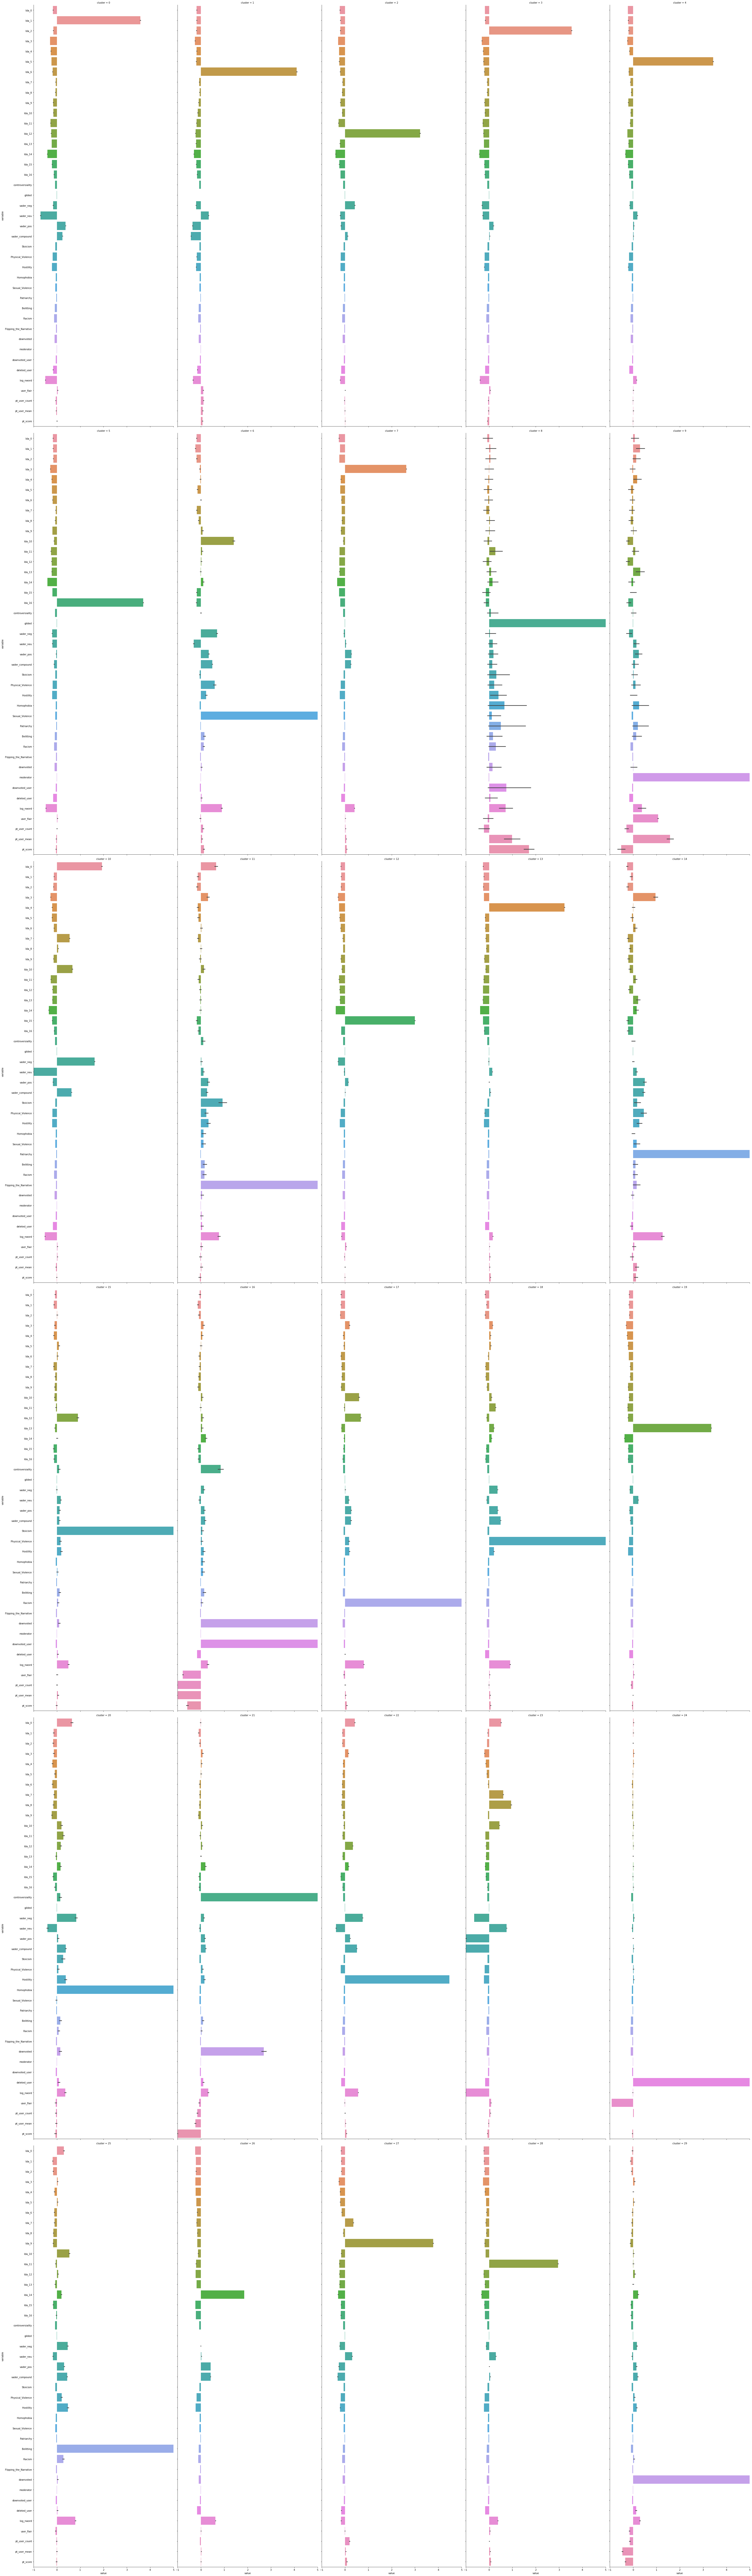

In [8]:
import seaborn as sns
melted = combined_df.set_index('cluster').melt(ignore_index = False).reset_index()

clust_compare2 = sns.catplot(data = melted,
                            x = 'value',
                            y = 'variable',
                            col = 'cluster',
                            kind = 'bar',
                            col_wrap = 5, 
                            height = 25,
                            aspect= .35).set(xlim = (-1,5))
# clust_compare.set_axis_labels('Average Proportion of 411 calls', 'Type of Call')


<AxesSubplot:xlabel='pt_user_mean', ylabel='pt_score'>

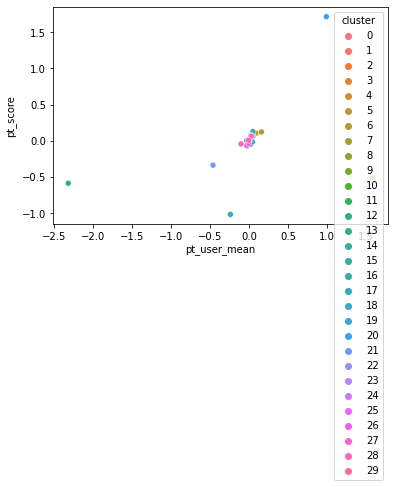

In [40]:
sns.scatterplot(data = sc_cluster, x = 'pt_user_mean', y='pt_score', hue='cluster')

In [9]:
from yellowbrick.cluster import silhouette_visualizer
silhouette_visualizer(KMeans(n_clusters = 30), combined_df, colors='yellowbrick')

KeyboardInterrupt: 

In [4]:
# #lets try another clustering approach - agglomerative
# from sklearn.cluster import AgglomerativeClustering
# agg = AgglomerativeClustering()
# agg.fit(combined_df)

MemoryError: Unable to allocate 8.27 TiB for an array with shape (1137117203596,) and data type float64

Agglomerative clustering needs to allocate an array of size 8.27 Terabytes... this isn't going to happen. 

In [ ]:
# #trying a density approach - DBScan
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score

# eps_opts = [0.01, 0.05, 0.1, 0.2]
# minsamples_opts = [100, 1000, 10000, 100000]

# plot_db = []
# mod_kmk = []
# for eps in eps_opts:
#     for minsamples in minsamples_opts:
#         db_tst = DBSCAN(eps=eps, min_samples=minsamples)
#         db_tst.fit_predict(combined_df)
#         plot_kmk.append(km_k.inertia_)
#         mod_kmk.append(km_k)

In [7]:
# #trying a density approach - DBScan
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score
# dbscan = DBSCAN()
# db_tst = DBSCAN(eps = .1, min_samples = 1000)
# db_tst.fit_predict(combined_df)

KeyboardInterrupt: 